# Tutorial

## Relevant imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyforfluids as pff

## Definition of the model to be used

In [2]:
model = pff.models.GERG2008()

## Fluid's initial state

In [29]:
temperature = 150  # Degrees Kelvin
density = 1  # mol/L
pressure = 101325  # Pa
composition = {'methane': 0.9, 'ethane': 0.05, 'propane': 0.05}  # Molar fractions

### Definition of the fluid
The properties will be calculated at the moment of the object definition.

In [30]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    density=density
)

#### Pressure as an init variable
Pressure can be used as an initial variable, in this case the method `fluid.density_iterator` will be called internally to find the root of density at the given pressure, since all models use density as an independent variable instead of temperature. 

This can lead to trouble since multiple roots can be obtained in the equilibrium region!

In [32]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    pressure=pressure
)

/home/ruther/docs/programming/python/virtualenvs/pff/lib/python3.10/site-packages/pyforfluids/core.py:150: UserWarning: Two roots were found! Vapor-phase value will be used
  warnings.warn(


### Accessing properties

Properties are stored in the Fluid attribute `Fluid.properties` as a dictionary, they can either be accessed that way or by calling them directly from the fluid.

All the properties are expressed in **International System** units, except for density that's expressed in **[mol/L]**

In [33]:
fluid.properties

critical_density                                                          9.442773
critical_temperature                                                    207.106811
ideal_helmholtz                  [[-2.6909451721172486, 0.0, 0.0], [113.9540033...
residual_helmholtz               [[-0.01953281291620949, 0.0, 0.0], [-2.2290165...
compressibility_factor                                                    0.980439
isochoric_heat                                                           26.306793
isobaric_heat                                                            35.275533
sound_speed                                                             297.571758
isothermal_thermal_coefficent                                            -0.718794
dp_dt                                                                     0.701414
dp_drho                                                                1198.310467
dp_dv                                                                    -8.228284
pres

In [34]:
fluid['isochoric_heat']

26.306793214778345

### State changes

A fluid thermodynamic variable can be changed by using the methods:

- `Fluid.set_temperature`
- `Fluid.set_composition`
- `Fluid.set_density`
- `Fluid.set_pressure`

When a property is changed, the properties are not re-calculated, so it's a **must** to call the method `Fluid.calculate_properties`. This is intended to avoid useless calculations if two or more variables are to be changed. In the case of a pressure change `Fluid.density_iterator` will be called!

In [40]:
fluid.set_temperature(150)
fluid.set_density(2)

fluid.calculate_properties()

In [41]:
fluid['isochoric_heat']

261.17548580069865

## Calculating isotherms

Isotherms at the fluid temperature can be calculated along a density range with the method `Fluid.isotherm`. This will return a `pandas.DataFrame` that will account as all the `Fluid.properties` series calculated in it's range.

In [42]:
density_range = np.linspace(0.001, 20, 100)
isotherm = fluid.isotherm(density_range)

In [43]:
isotherm['isochoric_heat'][:5]

0    26.032715
1    26.785114
2    27.888103
3    29.636736
4    32.692315
Name: isochoric_heat, dtype: float64

<AxesSubplot:>

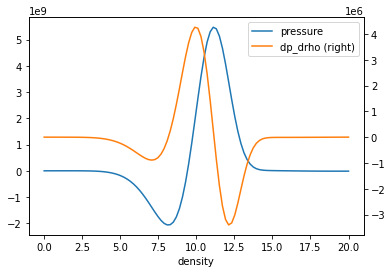

In [44]:
fig, ax = plt.subplots()

isotherm.set_index("density")[["pressure"]].plot(ax=ax)
isotherm.set_index("density")[["dp_drho"]].plot(ax=ax, secondary_y = True)